In [46]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [48]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
df.head()
df.isnull().sum()

title                              0
location                         354
description                        0
requirements                    2772
telecommuting                      0
has_company_logo                   0
has_questions                      0
fraudulent                         0
location_has_non_latin             0
description_has_non_latin          0
requirements_has_non_latin         0
has_requirements                   0
description_and_requirements       0
country_state                   2599
country                          354
has_location                       0
has_location_details               0
dtype: int64

In [49]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col]
y = y.values.ravel()

In [50]:
###########################
##### Train the model #####
###########################

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])


kF = KFold(n_splits=10, shuffle=True, random_state=42)

# Make predictions and print classification report
y_pred = cross_val_predict(model, X, y, cv=kF)
# y_log_pred_prob = cross_val_predict(model, X, y, cv=kF, method='predict_proba')[:, 1]

/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklea

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14538
           1       0.94      0.65      0.77      1197

    accuracy                           0.97     15735
   macro avg       0.96      0.82      0.87     15735
weighted avg       0.97      0.97      0.97     15735

F2 Score: 0.6888255212974514


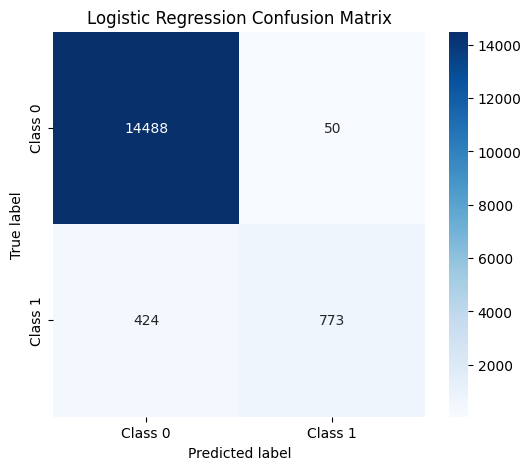

In [53]:
###########################
##### Display results #####
###########################
print("Classification Report:")
print(classification_report(y, y_pred))
print("F2 Score:", fbeta_score(y, y_pred, beta=2, average='binary'))
clf = model.named_steps["clf"]
# print(clf.coef_)
fbeta = make_scorer(fbeta_score, beta=2)
plot_confusion_matrix(confusion_matrix(y, y_pred, labels=[0, 1]), f"Logistic Regression Confusion Matrix")

In [54]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = 'models/logistic_regression_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)